In [1]:
%pylab notebook

# # Run on CPU not GPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers

import cupyck

import primo.models
import primo.datasets
# import primo.tools.filepath as filepaths
import primo.tools.sequences as seqtools
import pandas as pd


Populating the interactive namespace from numpy and matplotlib


In [2]:
sess_args = {
    "max_seqlen": 240
}
try:
    session = cupyck.GPUSession(**sess_args)
except RuntimeError:
    print "GPU startup failed. falling back to multicore backend."
    session = cupyck.MulticoreSession()
simulator = primo.models.Simulator(session)

In [3]:
# Load the model to be examined
encoder_20 = tf.keras.models.load_model('/tf/primo/data/models/encoder_model_20.h5')
encoder_80 = tf.keras.models.load_model('/tf/primo/data/models/encoder_model_80.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
### 
# Define utilities
###

def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def base_distribution(sequences):
    one_hots = one_hot(sequences)
    bases = np.sum(one_hots, axis=0)

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones(shape + (depth,), dtype=np.float32) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

def get_multiple_batchs(n, generator):
    indices = None
    values = None
    for _ in range(n):
        i, v = next(generator)
        if indices is None:
            indices = i
            values = v
        else:
            indices = np.concatenate([indices, i])
            values = np.concatenate([values, v])
    return indices, values

In [5]:
# ###
# # Load queries and see what they encode to
# ###
# query_features = pd.read_hdf('/tf/primo/data/queries/features.h5')
# query_seqs = seqtools.onehots_to_seqs(encoder.predict(query_features))
# print("Query Seqs: \n" + "\n".join(query_seqs))

# def seq_str_to_input(seq):
#     return np.transpose(seqtools.seqs_to_onehots(seq), [1, 0, 2])

In [6]:
###
# Use data batch generators to get a batch of random training and validation
# data
###encoder_1site_triplet_20220128_1

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar
        
batch_size = 200
similarity_threshold = 75

validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# Generators for balanced pairs
val_pair_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(batch_size, similarity_threshold), 
    similarity_threshold)

# Get pairs (50 batches x 200 batch size = 10k pairs)
val_feat_pairs, val_truth = get_multiple_batchs(50, val_pair_generator)


<IPython.core.display.Javascript object>


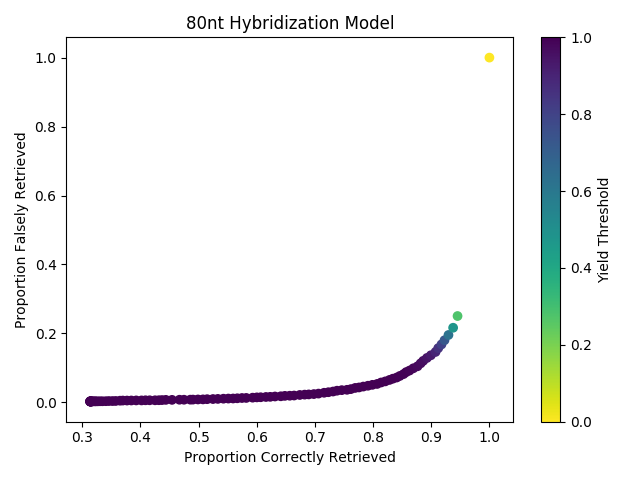

In [23]:
# Encode sequence pairs with the 20 nt hybridization encoder
# val_seq_pairs = one_hot(np.stack([
#     encoder_20.predict(val_feat_pairs[:, 0, :]).argmax(-1),
#     encoder_20.predict(val_feat_pairs[:, 1, :]).argmax(-1),
# ], axis=1)).astype(np.float32)

# Encode sequence pairs with the 80 nt hybridization encoder
val_seq_pairs = one_hot(np.stack([
    encoder_80.predict(val_feat_pairs[:, 0, :]).argmax(-1),
    encoder_80.predict(val_feat_pairs[:, 1, :]).argmax(-1),
], axis=1)).astype(np.float32)
    
# compare false positive returns to true returns
pairs_p = val_seq_pairs[val_truth > 0.5] #onehot vectors similar
pairs_n = val_seq_pairs[val_truth < 0.5] #onehot vectors dissimilar

# similar queries and targets
query_features_p = seqtools.onehots_to_seqs(pairs_p[:, 0, :]) 
target_features_p = seqtools.onehots_to_seqs(pairs_p[:, 1, :])

# dissimilar queries and targets
query_features_n = seqtools.onehots_to_seqs(pairs_n[:, 0, :])
target_features_n = seqtools.onehots_to_seqs(pairs_n[:, 1, :])

Yp = simulator.simulate(pd.DataFrame({
    'query_features': query_features_p,
    'target_features': target_features_p,
}))
Yn = simulator.simulate(pd.DataFrame({
    'query_features': query_features_n,
    'target_features': target_features_n,
}))

Yp_yield = Yp['duplex_yield']
Yn_yield = Yn['duplex_yield']

threshold_data = [] 
recall_data = []
false_positive_data = []

thresholds=1-np.logspace(-14, 0, 100)
for t in thresholds:
    recall = (Yp_yield > t).mean()
    false_positive = (Yn_yield > t).mean()
    threshold_data.append(t)
    recall_data.append(recall)
    false_positive_data.append(false_positive)
    
plt.figure()   
plt.scatter(recall_data, false_positive_data, c=threshold_data, cmap=plt.cm.viridis_r)
plt.xlabel("Proportion Correctly Retrieved")
plt.ylabel("Proportion Falsely Retrieved")
plt.colorbar(label="Yield Threshold")
plt.title("80nt Hybridization Model")
plt.tight_layout()
plt.savefig('80_hyb_retrieval_random_pair_simulations.png', bbox_inches='tight', dpi=1000)
plt.show()

In [24]:
print list(thresholds)

[0.99999999999999, 0.9999999999999861, 0.9999999999999808, 0.9999999999999735, 0.9999999999999633, 0.999999999999949, 0.9999999999999295, 0.9999999999999023, 0.9999999999998647, 0.9999999999998126, 0.9999999999997405, 0.9999999999996406, 0.9999999999995023, 0.9999999999993108, 0.9999999999990454, 0.9999999999986781, 0.9999999999981692, 0.9999999999974646, 0.9999999999964888, 0.9999999999951374, 0.9999999999932658, 0.999999999990674, 0.9999999999870846, 0.9999999999821135, 0.9999999999752293, 0.9999999999656953, 0.9999999999524919, 0.9999999999342066, 0.9999999999088838, 0.9999999998738143, 0.9999999998252471, 0.9999999997579871, 0.9999999996648398, 0.9999999995358411, 0.9999999993571926, 0.9999999991097849, 0.9999999987671533, 0.9999999982926474, 0.9999999976355106, 0.9999999967254508, 0.9999999954651215, 0.9999999937197086, 0.9999999913025099, 0.9999999879549646, 0.9999999833189946, 0.999999976898703, 0.9999999680073286, 0.9999999556937854, 0.9999999386409273, 0.9999999150246565, 0.99

In [25]:
print false_positive_data

[0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.0027994401119776045, 0.003199360127974405, 0.003199360127974405, 0.003199360127974405, 0.003199360127974405, 0.003199360127974405, 0.0033993201359728054, 0.0033993201359728054, 0.003599280143971206, 0.003999200159968006, 0.003999200159968006, 0.004199160167966407, 0.004999000199960008, 0.005398920215956809, 0.005398920215956809, 0.005598880223955209, 0.0057988402319536095, 0.0057988402319536095, 0.0061987602479504095, 0.0061987602479504095, 0.0061987602479504095, 0.00639872025594881, 0.006798640271945611, 0.007398520295940812, 0.007398520295940812, 0.007798440311937612, 0.007798440311937612, 0.007998400319936013, 0.008198360327934412, 0.008598280343931213, 0.008798240351929614, 0.009398120375924815, 0.009798040391921616, 0.010197960407918417, 0.010797840431913617, 0.0111977604479

In [26]:
print recall_data

[0.3134626925385077, 0.3134626925385077, 0.3136627325465093, 0.3136627325465093, 0.3138627725545109, 0.3138627725545109, 0.3146629325865173, 0.3146629325865173, 0.3156631326265253, 0.3162632526505301, 0.3168633726745349, 0.3186637327465493, 0.3214642928585717, 0.3232646529305861, 0.3264652930586117, 0.33046609321864373, 0.33466693338667736, 0.34046809361872377, 0.34566913382676534, 0.351870374074815, 0.35747149429885977, 0.36487297459491896, 0.36967393478695737, 0.376875375075015, 0.3842768553710742, 0.39267853570714145, 0.40188037607521504, 0.40868173634726945, 0.4158831766353271, 0.4250850170034007, 0.4316863372674535, 0.4370874174834967, 0.4436887377475495, 0.45429085817163434, 0.46709341868373677, 0.47489497899579913, 0.48569713942788556, 0.4902980596119224, 0.4988997799559912, 0.50750150030006, 0.5147029405881176, 0.5247049409881976, 0.5331066213242649, 0.5427085417083417, 0.5511102220444088, 0.5593118623724745, 0.5665133026605321, 0.5745149029805962, 0.5819163832766553, 0.5929185

# OLD
This code was used to examine preliminary relationships, it has been refactored above

In [ ]:
###
# Use data batch generators to get a batch of random training and validation
# data
###encoder_1site_triplet_20220128_1

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

batch_size = 200
similarity_threshold = 75
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')
 
# # Generator for triplets
# train_triplet_generator = primo.datasets.dataset.triplet_batch_generator(
#     train_dataset.random_features(batch_size),
#     similarity_threshold
# )

# val_triplet_generator = primo.datasets.dataset.triplet_batch_generator(
#     validation_dataset.random_features(batch_size),
#     similarity_threshold
# )

# Generators for balanced pairs
train_pair_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)
val_pair_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

# batch = next(batch_generator)
# del batch_generator

# val_batch = next(encoder_val_batches)
# del encoder_val_batches

In [ ]:
def plot_pair_scatter(seq_pairs, y_true, title):
    pairs_p = seq_pairs[y_true > 0.5] #one hot vectors
    pairs_n = seq_pairs[y_true < 0.5]
    
#     print pairs_p.shape()
    # Compute the log10 scores for positive (similar) pairs
#     Yp = log_multisite_predictor(pairs_p).numpy()
    # Compute the log10 score for negative (dis-similar) pairs
#     Yn = log_multisite_predictor(pairs_n).numpy()
    
    query_features_p = seqtools.onehots_to_seqs(pairs_p[:, 0, :]) # reference
    target_features_p = seqtools.onehots_to_seqs(pairs_p[:, 1, :])
    query_features_n = seqtools.onehots_to_seqs(pairs_n[:, 0, :])
    target_features_n = seqtools.onehots_to_seqs(pairs_n[:, 1, :])
    Yp = simulator.simulate(pd.DataFrame({
        'query_features': query_features_p,
        'target_features': target_features_p,
    }))['duplex_yield']
    Yn = simulator.simulate(pd.DataFrame({
        'query_features': query_features_n,
        'target_features': target_features_n,
    }))['duplex_yield']
    
    recall = (Yp > 10**(-10.0)).mean()
    false_positive = (Yn > 10**(-10.0)).mean()
    
#     Yn=pairs_p[:, 1, :] # target
    
#     Yp = seqtools.onehots_to_seqs(Yp)
#     print Yp
#     Yn = seqtools.onehots_to_seqs(Yn)
#     #make ref and target into appropriate df
#     target_query_df = pd.DataFrame(list(zip(Yp, Yn)), columns = ['query_features', 'target_features'])
#     results = simulator.simulate(target_query_df) # creates df with last column 'duplex_yield'
#     duplex_yield = results["duplex_yield"]
#     target_query_df = target_query_df.join(duplex_yield)

    #     thresholds=1-np.logspace(-14, 0, 100)
#     recall = (Yp > 10**(-10.0)).mean()
#     false_positive = (Yn > 10**(-10.0)).mean()

#     print("recall: {}, false_positive: {}".format([recall, false_positive]))

    plt.figure()
    plt.plot(Yp, '.', label='pos')
    plt.plot(Yn, 'x', label='neg')
    plt.legend()
    plt.title('{} - recall: {:.2f}, false positive: {:.2f}'.format(title, recall, false_positive))

val_feat_pairs, val_truth = get_multiple_batchs(10, val_pair_generator)
val_seq_pairs = one_hot(np.stack([
    encoder.predict(val_feat_pairs[:, 0, :]).argmax(-1),
    encoder.predict(val_feat_pairs[:, 1, :]).argmax(-1),
], axis=1)).astype(np.float32)

train_feat_pairs, train_truth = get_multiple_batchs(10, train_pair_generator)
train_seq_pairs = one_hot(np.stack([
    encoder.predict(train_feat_pairs[:, 0, :]),
    encoder.predict(train_feat_pairs[:, 1, :]),
], axis=1).argmax(-1))

plot_pair_scatter(val_seq_pairs, val_truth, 'Validation Data')
plot_pair_scatter(train_seq_pairs, train_truth, 'Train Data')

In [ ]:
def nn_recall(scores, distances, k=10, n_thresholds=500, thresholds=None):
    
    if thresholds is None:
        thresholds = np.linspace(scores.min(), scores.max(), n_thresholds)
        thresholds[0] = (thresholds[0] + thresholds[1])/2
        
    retrieved = scores >= thresholds.reshape(-1,1)
    p_retrieved = retrieved.mean(1)
    
    neighbors = distances.argsort()[:k]
    
    nn_recall = retrieved[:, neighbors].mean(1)
    
    return nn_recall, p_retrieved, thresholds

n,p,t = nn_recall(
    df.duplex_yield.values/df.duplex_yield.max(),
    df.euclidean_distance.values,
    k=100,
    thresholds=1-np.logspace(-14, 0, 100)
)

plt.scatter(n,p,c=t, cmap=plt.cm.viridis_r)
plot_baselines(100, len(df))(plt.gca())
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")
plt.colorbar(label="Yield Threshold")

In [ ]:
### Sequence Confidence and Variation
#
# Get a random set of validation features and encode to sequences, then 
# plot the confidence and variation (entropy) of the sequence pool
# for each sequence position. 

# _, example_features = next(validation_dataset.random_features(500))
# _, example_features = next(train_dataset.random_features(500))

seqs_softmax = encoder.predict(example_features)
seqs_onehot = one_hot(seqs_softmax.argmax(-1))

unique_seqs = np.unique(seqs_onehot, axis=0)
sequence_uniqueness = len(unique_seqs) / len(seqs_onehot)

base_distributions = seqs_onehot.sum(0) / len(seqs_onehot)
seqlen = seqs_onehot.shape[1]

confidence = confidence_by_base(seqs_softmax)
entropy = entropy_by_base(seqs_softmax)

seqlen = seqs_softmax.shape[1]
fig = plt.figure(figsize=[7, 7])
# fig.suptitle(f'Sequence Uniqueness = {sequence_uniqueness:0.2f}')
axes = fig.subplots(3,1)

ax = axes[0]
ax.bar(np.arange(0, seqlen), confidence)
ax.set_title('confidence')

ax = axes[1]
ax.bar(np.arange(0, seqlen), entropy)
ax.set_title('entropy')

ax = axes[2]
ax.set_title('base distribution')
ax.set_xlabel('sequence position')
bottom = np.zeros_like(base_distributions[:, 0])
ax.bar(np.arange(seqlen), base_distributions[:, 0], label='A', )
bottom += base_distributions[:, 0]
ax.bar(np.arange(seqlen), base_distributions[:, 1], label='T', bottom=bottom)
bottom += base_distributions[:, 1]
ax.bar(np.arange(seqlen), base_distributions[:, 2], label='C', bottom=bottom)
bottom += base_distributions[:, 2]
ax.bar(np.arange(seqlen), base_distributions[:, 3], label='G', bottom=bottom)
ax.legend(bbox_to_anchor=(1.15, 0.9))

plt.tight_layout()